Notes
    
        
- Heaviside step function
- def step_fun(x,a,b,c): return a * (np.sign(x-b) + c)
- p0=[np.max(y), np.median(x), np.min(y)]


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
from scipy.optimize import curve_fit
from mplcursors import cursor
from dataclasses import dataclass
print("done")

done


In [2]:
def step_sim(step_size = 8.0, SNR = 0.5, total_time_point=400):
    np.random.seed(20181118)
    
    steps = np.piecewise(np.arange(0, total_time_point), 
                            [
                                np.arange(0, total_time_point) < 99, 

                                np.logical_and(np.arange(0, total_time_point) >= 99, np.arange(0, total_time_point) < 199), 

                                np.logical_and(np.arange(0, total_time_point) >= 199, np.arange(0, total_time_point) < 249), 
                                
                                np.logical_and(np.arange(0, total_time_point) >= 249, np.arange(0, total_time_point) < 349), 
                                
                                np.logical_and(np.arange(0, total_time_point) >= 349, np.arange(0, total_time_point) < 499), 

                                np.arange(0, total_time_point) >= 499
                            ], 
                            [
                                lambda x: 300, 
                                lambda x: 100, 
                                lambda x: 50, 
                                lambda x: 350,
                                lambda x: 20,
                                lambda x: 350,
                            ])
    x = np.arange(0, total_time_point)
    noise_STD = step_size / SNR
    noise = np.random.normal(scale=noise_STD, size=len(x))
    # y = true_fct + np.random.standard_t(1, size=len(x))
    y = steps + noise
    return x, y, steps
print("done")

done


In [50]:

def moving_average(a, n=2, pad=False) :
    if pad:
        a = np.pad(a, (n-1,0))
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

@dataclass(repr=True)
class StepInfo:
    L:float
    x0:int
    k:float
    b:float
    location:float
    x:np.ndarray=None
    y:np.ndarray=None
    sqrt_error:np.ndarray=None
    

def _step_fun(x, L ,x0, k, b):
    # Logistic function
    # f(X, L, x0, k, b)
    # https://en.wikipedia.org/wiki/Logistic_function
    # use for curve fitting
    # https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return y

def get_step_location_size(x, y):
    p0=[np.max(y), np.median(x),1, np.min(y)]
    popt, pcov, infodict, mesg, ier = curve_fit(_step_fun, x, y,p0=p0, full_output=True, maxfev = 1000000)
    L , x0, k, b = popt
    
#     uniques, indices, counts = np.unique(np.round(fit_y), return_counts=True, return_index=True)
    
    sqrt_error = np.sqrt(infodict['fvec']**2)
    location = x[np.where(sqrt_error==np.min(sqrt_error))[0][0]]
    info = StepInfo(L , x0, k, b, location, x, y, sqrt_error)
    
    ################
    y_fit = _step_fun(x, L, x0, k, b)

    uniques, indices, counts = np.unique(y_fit, return_counts=True, return_index=True)

    _indices =np.sort(indices)

    new_y = np.zeros(shape=y.shape)
    window_information = []
    for index, location in enumerate(_indices):
        if index == 0:
            new_y[0:location+1] = np.mean(y_data[0:location+1])
            window_loc = (x[0], x[location])
            window_information.append({'mean':np.mean(y[0:location+1]), 'window_loc':window_loc, 'window_size': abs(window_loc[1]-window_loc[0]) })
        else:
            pre_s = _indices[index-1]
            cur_s = _indices[index]
#             print(f"pre_s:{pre_s},cur_s:{cur_s}, len(x):{len(x)}, len(y):{len(y)}" )
            new_y[pre_s +1:cur_s+1] = np.mean(y[pre_s +1:cur_s+1])
            window_loc = (x[pre_s +1], x[cur_s])
            window_information.append({'mean':np.mean(y_data[pre_s +1:cur_s+1]), 'window_loc':window_loc, 'window_size': abs(window_loc[1]-window_loc[0])  })

        if index == len(indices)-1:
            new_y[location +1:] = np.mean(y[location +1:])
            window_loc = (x[location], x[-1]) if location == len(x)-1 else (x[location +1], x[-1])
            window_information.append({'mean':np.mean(y_data[location +1:]), 'window_loc':window_loc, 'window_size': abs(window_loc[1]-window_loc[0]) })


    y_std = np.std(y)
    selected_wins = []
    for index, win in enumerate(window_information):
        if (index+1) != (len(window_information)):
            window_hight = abs(win['mean'] - window_information[index+1]['mean'])
            if window_hight > y_std :
                selected_wins.append( win)
    if not len(selected_wins):
        return None
    selected_wins.sort( key=lambda x : x['window_size'] )
                                    
    window = selected_wins[-1]
    ################

    step = StepInfo(L , x0, k, b, window['window_loc'][-1])
    return step

def step_generator(x:np.ndarray, y:np.ndarray, steps:list, window_size_limit:int = 40):
    info = get_step_location_size(x, y)
    if info is None:
        return
    steps.append(info)
    location_index = np.where(x == info.location)[0][0]
    
    left_x = x[:location_index]
    left_y = y[:location_index]
    if len(left_y) > window_size_limit:
        step_generator(left_x, left_y, steps)
        
    right_x = x[location_index+1:]
    right_y = y[location_index+1:]
    if len(right_y)>window_size_limit:
        step_generator(right_x, right_y, steps)


def get_y_from_step_locations(steps, y):
    # Generate the new steped data using the step locations and the orignal y data
    new_y = np.zeros(shape=y.shape)
    for index, s in enumerate(steps):
        if index == 0:
            new_y[0:s.location+1] = np.mean(y[0:s.location+1])
        else:
            pre_s = steps[index-1]
            cur_s = steps[index]
            new_y[pre_s.location +1:cur_s.location+1] = np.mean(y[pre_s.location +1:cur_s.location+1])
    
        if index == len(steps)-1:
            new_y[s.location +1:] = np.mean(y[s.location +1:])
    return new_y
print("done")

done


In [51]:
x_data, y_data , steps_org = step_sim(total_time_point=600)

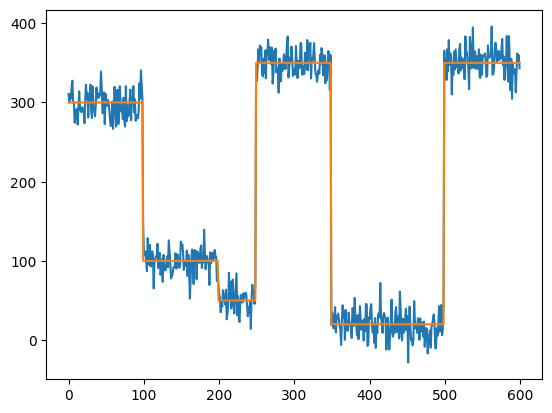

In [52]:
plt.plot(x_data, y_data, label="raw")
plt.plot(x_data, steps_org, label="expected")

In [53]:
# step = get_step_location_size(x_data, y_data)
# y_fit = _step_fun(x_data, step.L, step.x0, step.k, step.b)

# uniques, indices, counts = np.unique(y_fit, return_counts=True, return_index=True)

# _indices =np.sort(indices)

# new_y = np.zeros(shape=y_data.shape)
# check_array = []
# for index, location in enumerate(_indices):
#     if index == 0:
#         new_y[0:location+1] = np.mean(y_data[0:location+1])
#         check_array.append({'std:':np.std(y_data[0:location+1]), 'mean':np.mean(y_data[0:location+1]), 'window':(0, location) })
#     else:
#         pre_s = _indices[index-1]
#         cur_s = _indices[index]
#         new_y[pre_s +1:cur_s+1] = np.mean(y_data[pre_s +1:cur_s+1])
#         check_array.append({'std:':np.std(y_data[pre_s +1:cur_s+1]), 'mean':np.mean(y_data[pre_s +1:cur_s+1]), 'window':(pre_s +1, cur_s)  })

#     if index == len(indices)-1:
#         new_y[location +1:] = np.mean(y_data[location +1:])
#         check_array.append({'std:':np.std(y_data[location +1:]), 'mean':np.mean(y_data[location +1:]), 'window':(location+1,len(y_data)-1) })



# print(f"uniques:{uniques}, indices:{indices}, counts:{counts}")
# print(check_array)
# y_std = np.std(y_data)
# selected_win = None
# for index, win in enumerate(check_array):
#     if (index+1) != (len(check_array)):
#         window_hight = abs(win['mean'] - check_array[index+1]['mean'])
#         print(window_hight)
#         if window_hight > y_std :
#             selected_win = check_array[index]
# print(selected_win)
# print(y_std)
# # plt.plot(x_data, y_data, label="raw")
# # plt.plot(x_data, y_fit, label="step1")
# # plt.plot(x_data, new_y, label="step1_new")

In [59]:
steps = []
step_generator(x_data, y_data, steps)
steps.sort(key=lambda x: x.location)
y_check = get_y_from_step_locations(steps, y_data)

C:\Users\CellphyLab\AppData\Local\Temp\ipykernel_2616\4209693951.py:26: RuntimeWarning: overflow encountered in exp
  y = L / (1 + np.exp(-k*(x-x0))) + b


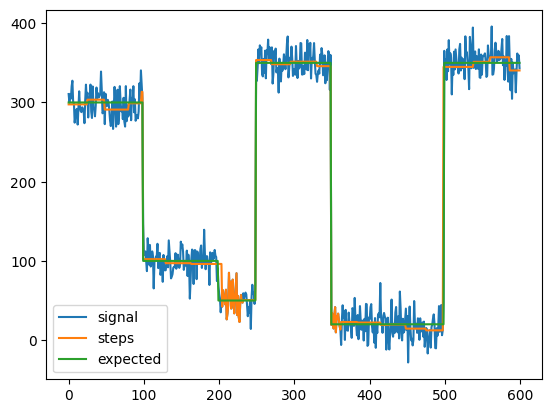

In [60]:
plt.plot(x_data, y_data, label="signal")
plt.plot(x_data, y_check, label="steps")
plt.plot(x_data, steps_org, label="expected")
plt.legend()

In [58]:
steps

[StepInfo(L=-67.74641142337659, x0=348.3575698074689, k=76.16289667023504, b=220.7618434328121, location=348, x=None, y=None, sqrt_error=None),
 StepInfo(L=181.27826442555556, x0=248.89409186811454, k=22.144786646604118, b=168.83693340899046, location=248, x=None, y=None, sqrt_error=None),
 StepInfo(L=-213.7385702186162, x0=98.94655209448702, k=16.23983663299247, b=297.3901814746867, location=98, x=None, y=None, sqrt_error=None),
 StepInfo(L=-6.324756432409051, x0=44.519973058664995, k=16.175741691028016, b=300.73188450406536, location=47, x=None, y=None, sqrt_error=None),
 StepInfo(L=8.038507278484067, x0=21.912313687825687, k=20.65928731842745, b=295.90306689048117, location=24, x=None, y=None, sqrt_error=None),
 StepInfo(L=30.92618193704838, x0=93.52800355459902, k=14.858231274960778, b=291.85237837473085, location=96, x=None, y=None, sqrt_error=None),
 StepInfo(L=6.383687808460858, x0=80.49963109000863, k=16.258199515550682, b=290.7997862552251, location=79, x=None, y=None, sqrt_er